In [2]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'


## Load MNIST Dataset

- **`root='data/'`**: Directory to store or load the dataset.  
- **`download=True`**: Automatically downloads the dataset if not found locally.  
- **`transform=ToTensor()`**: Converts PIL images to PyTorch tensors with pixel values scaled to `[0, 1]`.

In [3]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())


## Inspect a Sample from the MNIST Dataset

- **`image, label = dataset[0]`**: Retrieves the first image and its corresponding label from the dataset.  
- **`image.shape`**: Prints the tensor shape of the image. For MNIST with `ToTensor()`, this is typically `(1, 28, 28)` — (channels, height, width).  
- **`image.permute(1, 2, 0)`**: Rearranges dimensions from `(C, H, W)` to `(H, W, C)` so `matplotlib` can display it correctly.  
- **`cmap='gray'`**: Displays the image in grayscale, matching MNIST’s single-channel format.  
- **`label`**: The true digit (0–9) associated with the image.

image.shape torch.Size([1, 28, 28])
Label: 5


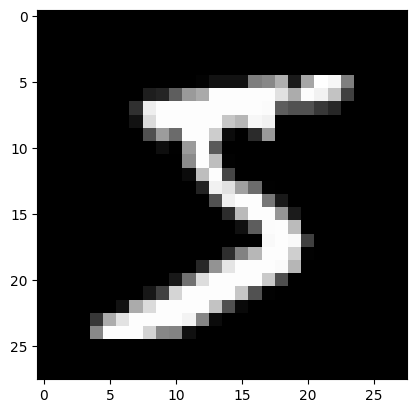

In [4]:
image , label = dataset[0]
print('image.shape', image.shape)
plt.imshow(image.permute(1,2,0),cmap='gray')
print('Label:', label)

## Split Dataset into Training and Validation Sets

- **`val_size = 10000`**: Defines the number of samples to reserve for validation.  
- **`train_size = len(dataset) - val_size`**: Computes the remaining samples for training (60,000 for MNIST).  
- **`random_split(...)`**: Randomly splits the dataset into two subsets:  
  - `train_ds`: Training set (60,000 samples)  
  - `val_ds`: Validation set (10,000 samples)  
- The final line returns the sizes of both subsets to verify the split.

In [5]:
val_size=10000
train_size=len(dataset)-val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

## Create Data Loaders

- **`batch_size = 128`**: Number of samples per batch for the training loader.  
- **`train_loader`**:  
  - Loads data from `train_ds` in batches of 128.  
  - `shuffle=True` randomizes the order of samples in each epoch for better generalization.  
- **`val_loader`**:  
  - Uses a larger batch size (`256`) for faster validation.  
  - `num_workers=4` enables multi-process data loading to speed up preprocessing.  
  - `pin_memory=True` optimizes GPU memory transfer by allocating data in pinned (page-locked) memory.

In [6]:
batch_size=128

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Visualize a Batch of Training Images

- **`for images, _ in train_loader:`**: Iterates over the training data loader; ignores labels (`_`).  
- **`images.shape`**: Prints the shape of the batch (e.g., `[128, 1, 28, 28]` → 128 images, 1 channel, 28×28 pixels).  
- **`plt.figure(figsize=(16,8))`**: Sets the figure size for better visibility.  
- **`make_grid(images, nrow=16)`**: Arranges the batch of images into a single grid with 16 images per row.  
- **`.permute((1,2,0))`**: Reorders tensor dimensions from (C, H, W) to (H, W, C) for correct display with `matplotlib`.  
- **`plt.axis('off')`**: Hides axis ticks and labels for a cleaner look.  
- **`break`**: Stops after the first batch to avoid plotting multiple grids.

images.shape: torch.Size([128, 1, 28, 28])


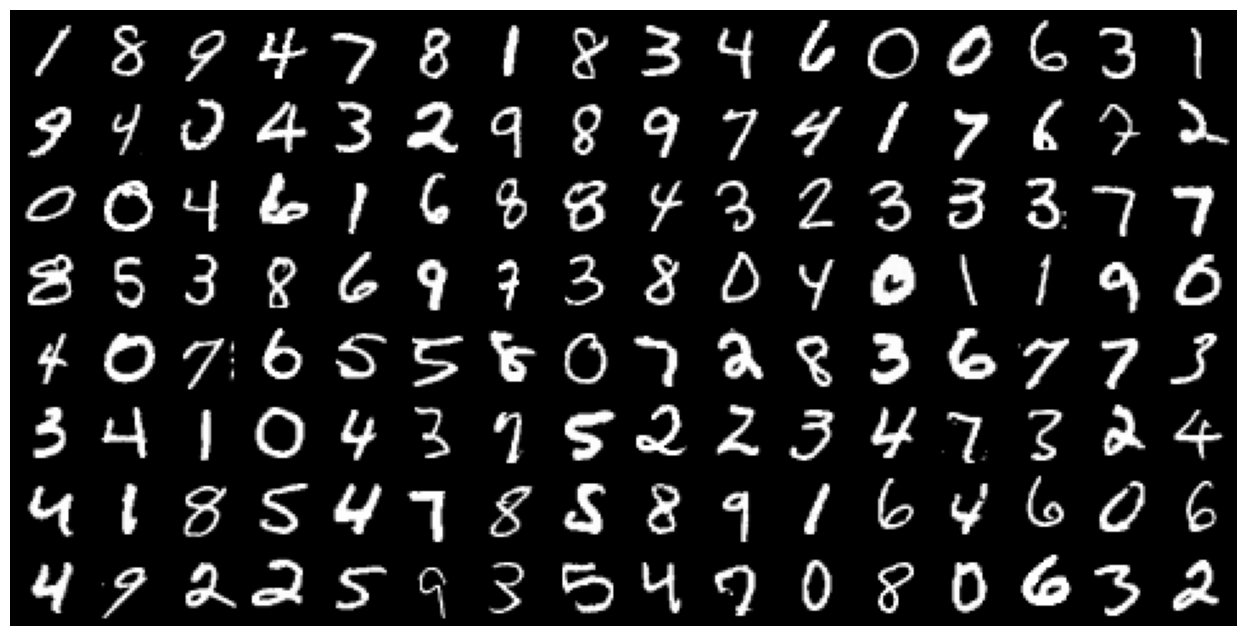

In [7]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1,2,0)))
    break

In [8]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    print('grid.shape:', make_grid(images, nrow=16).shape)
    break
    

images.shape: torch.Size([128, 1, 28, 28])
grid.shape: torch.Size([3, 242, 482])


## Flatten Input Images for Fully Connected Networks

- **`for images, labels in train_loader:`**: Loads one batch of images and their labels.  
- **`images.shape`**: Shows the original batch shape (e.g., `[128, 1, 28, 28]`).  
- **`images.reshape(-1, 784)`**: Flattens each 28×28 image into a 784-dimensional vector (since 28 × 28 = 784).  
- **`inputs.shape`**: Confirms the new shape (e.g., `[128, 784]`), suitable for feeding into a fully connected neural network.  
- **`break`**: Exits after processing the first batch.

In [9]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs=images.reshape(-1,784)
    print('inputs.shape', inputs.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape torch.Size([128, 784])


## Define Network Layer Sizes

- **`input_size = inputs.shape[-1]`**: Sets the input size to 784 (the number of flattened pixel features from a 28×28 MNIST image).  
- **`hidden_size = 32`**: Defines the number of neurons in the hidden layer of the neural network.

In [10]:
input_size=inputs.shape[-1]
hidden_size=32

## Create First Linear Layer

- **`nn.Linear(input_size, hidden_size)`** defines a fully connected (dense) layer that:
  - Takes **784 input features** (flattened image pixels).
  - Outputs **32 features** (one for each neuron in the hidden layer).
- This layer learns a weight matrix of shape `(32, 784)` and a bias vector of size `32` to transform the input.

In [11]:
layer1=nn.Linear(input_size, hidden_size)

In [12]:
inputs.shape

torch.Size([128, 784])

In [13]:
layer1_outputs=layer1(inputs)
layer1_outputs.shape

torch.Size([128, 32])

In [14]:
relu_outputs=F.relu(layer1_outputs)
print('relu_outputs.shape:', relu_outputs.shape)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('mix(relu_outputs):', torch.min(relu_outputs).item())

relu_outputs.shape: torch.Size([128, 32])
min(layer1_outputs): -0.6492708921432495
mix(relu_outputs): 0.0


In [15]:
output_size=10
layer2=nn.Linear(hidden_size, output_size)

In [16]:
layer2_outputs=layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [17]:
inputs.shape

torch.Size([128, 784])

In [18]:
relu_outputs.shape

torch.Size([128, 32])

In [19]:
layer2_outputs.shape

torch.Size([128, 10])

In [42]:
class MnistModel(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, out_size)

    def forward(self, xb):
        xb = xb.view(xb.size(0), -1)
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()

        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()

        return {
            'val_loss': epoch_loss.item(),
            'val_acc': epoch_acc.item()
        }
    
    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch}], val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")


In [43]:
def accuracy(outputs, labels):
    _, preds= torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [44]:
input_size=784
hidden_size=32
num_classes=10

In [45]:
model=MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [48]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [55]:
for images, labels in train_loader:
    outputs=model(images)
    break

loss=F.cross_entropy(outputs, labels)
print('loss:', loss.item())
print('output.shape:', outputs.shape)
print('sample outputs:\n', outputs[:2].data)

RuntimeError: Expected all tensors to be on the same device, but got mat1 is on cuda:0, different from other tensors on cpu (when checking argument in method wrapper_CUDA_addmm)

In [49]:
torch.cuda.is_available()

True

In [50]:
!nvidia-smi


Thu Dec  4 06:10:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   72C    P0             31W /   70W |     302MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [51]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


In [52]:
device=get_default_device()
device

device(type='cuda')

In [53]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
        

In [54]:
for images, labels in train_loader:
    print(images.shape)
    print(images.device)
    images=to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cuda:0
cuda:0


In [32]:
class DeviceDataLoader():
    def __init__(self, dl , device):
        self.dl=dl
        self.device=device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [33]:
def some_numbers():
    yield 10 
    yield 20
    yield 30

for value in some_numbers():
    print(value)

10
20
30


In [34]:
train_loader=DeviceDataLoader(train_loader, device)
val_loader=DeviceDataLoader(val_loader, device)

In [56]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb', yb)
    break

xb.device: cuda:0
yb tensor([7, 9, 8, 4, 1, 0, 9, 3, 5, 7, 6, 6, 1, 5, 2, 0, 9, 1, 5, 2, 7, 3, 0, 5,
        7, 1, 5, 8, 3, 4, 3, 9, 0, 3, 9, 8, 2, 0, 7, 8, 4, 7, 8, 6, 8, 8, 6, 7,
        7, 8, 3, 0, 3, 7, 1, 7, 8, 7, 8, 6, 0, 3, 8, 3, 5, 2, 3, 3, 2, 7, 4, 5,
        4, 6, 3, 0, 5, 9, 1, 3, 4, 0, 8, 0, 5, 0, 7, 2, 5, 5, 7, 7, 6, 9, 0, 2,
        1, 5, 3, 3, 0, 7, 8, 9, 1, 9, 2, 7, 5, 3, 7, 8, 4, 6, 0, 3, 5, 4, 9, 2,
        3, 5, 9, 9, 2, 2, 5, 0, 7, 7, 3, 1, 5, 1, 8, 1, 6, 5, 1, 3, 3, 5, 8, 7,
        4, 9, 4, 9, 3, 1, 3, 9, 0, 0, 4, 9, 4, 9, 8, 5, 2, 7, 3, 9, 0, 5, 0, 4,
        2, 1, 2, 4, 7, 1, 6, 0, 0, 3, 3, 6, 6, 6, 9, 4, 6, 9, 0, 1, 3, 7, 8, 2,
        7, 1, 4, 1, 7, 6, 1, 5, 9, 3, 6, 1, 2, 9, 6, 4, 7, 0, 2, 6, 8, 8, 6, 6,
        8, 3, 5, 1, 1, 8, 7, 1, 5, 2, 5, 8, 7, 1, 8, 9, 4, 7, 6, 1, 8, 9, 4, 7,
        4, 6, 4, 7, 3, 9, 7, 8, 6, 8, 1, 8, 5, 8, 6, 1], device='cuda:0')


In [57]:
def evaluate(model, val_loader):
    outputs=[model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history=[]
    optimizer=opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        for batch in train_loader:
            loss=model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result=evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [58]:
model=MnistModel(input_size, hidden_size=hidden_size, out_size=output_size)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [59]:
history=[evaluate(model, val_loader)]
history

[{'val_loss': 2.2983269691467285, 'val_acc': 0.119140625}]

In [61]:
history+=fit(5, 0.1, model, train_loader, val_loader)


Epoch [0], val_loss: 0.1164, val_acc: 0.9649
Epoch [1], val_loss: 0.1112, val_acc: 0.9673
Epoch [2], val_loss: 0.1117, val_acc: 0.9667
Epoch [3], val_loss: 0.1107, val_acc: 0.9669
Epoch [4], val_loss: 0.1098, val_acc: 0.9671


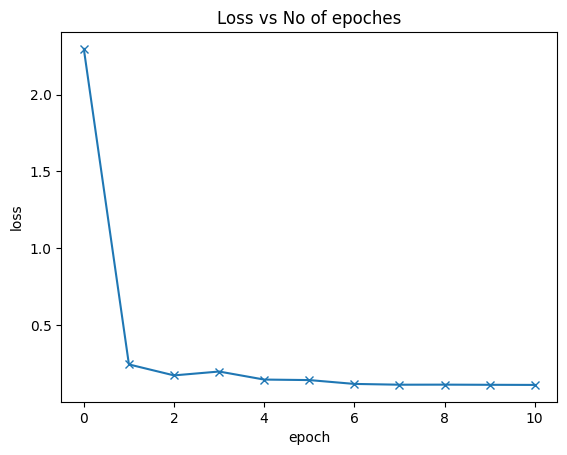

In [62]:
losses=[x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs No of epoches');

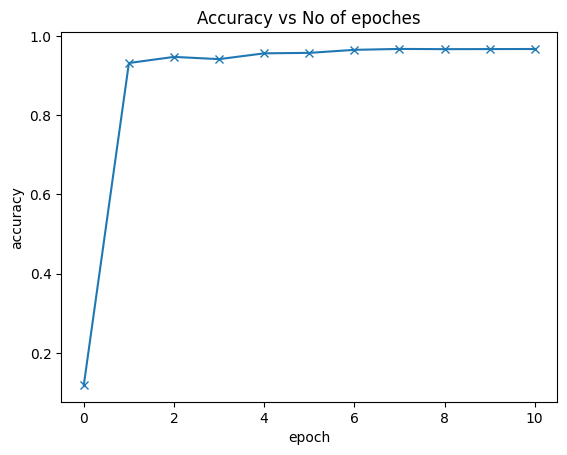

In [63]:
accuracies=[x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs No of epoches');